Практическое задание 1: Линейная регрессия, метод градиентного спуска

1) Найти данные, на которых интересно будет решать задачу регрессии. Зависимость целового признака от нецелевых должна быть не слишком сложной, чтобы обученная линейная модель смогла показать приемлимый результат.
 - в данном случае взята база данных прочности бетона в зависимости от концентрации входяших в него компонент.
 Источник - https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

raw_data = pd.read_excel("data/Concrete_Data.xls")
raw_data.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


Нецелевые параметры (все количественные)
Cement (component 1) -- kg in a m3 mixture 
Blast Furnace Slag (component 2) -- kg in a m3 mixture
Fly Ash (component 3) -- kg in a m3 mixture
Water (component 4) -- kg in a m3 mixture
Superplasticizer (component 5) -- kg in a m3 mixture
Coarse Aggregate (component 6) -- kg in a m3 mixture
Fine Aggregate (component 7) -- kg in a m3 mixture
Age -- Day (1~365)  

Целевой параметр
Concrete compressive strength -- MPa 

2) Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных
- проверим данные на наличие пропусков
- переименуем заголовки столбцов для удобства

In [2]:
raw_data.isnull().sum()

Cement (component 1)(kg in a m^3 mixture)                0
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    0
Fly Ash (component 3)(kg in a m^3 mixture)               0
Water  (component 4)(kg in a m^3 mixture)                0
Superplasticizer (component 5)(kg in a m^3 mixture)      0
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     0
Fine Aggregate (component 7)(kg in a m^3 mixture)        0
Age (day)                                                0
Concrete compressive strength(MPa, megapascals)          0
dtype: int64

In [3]:
data = raw_data.set_axis(['Cement', 'Slag', 'Ash', 'Water', 'Superplasticizer','Coarse', 'Fine', 'Age', 'Strength'], axis=1, copy=True)
data.describe()

,Cement,Slag,Ash,Water,Superplasticizer,Coarse,Fine,Age,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


Из вывода видно, что в данных нет пропусков. Также можно отметить следующие особенности:
* более четверти образцов вообще не имеют шлака или суперпластификатора, а более половины - золы.
* более 75% образцов не старше 2 месяцев.
Это может негативно сказаться на обучении модели, особенно в случае кросс-валидации. Так как в выборки могут попасть данные только с тривиальными значениями в конкретной колонке. Стоит учитывать этот момент при разделени на тестовую и обучающую выборки.

3) Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.

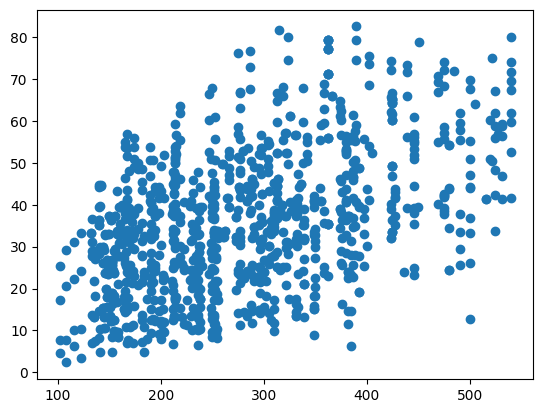

In [4]:
plt.scatter(x=data['Cement'] , y=data['Strength'])

Из графика выше видно, что количесвто цемента (ожидаемо) является показательной характеристикой прочности бетона. При массе меньше 300, невозможно достичь наивысшего качества, подбором других параметров.

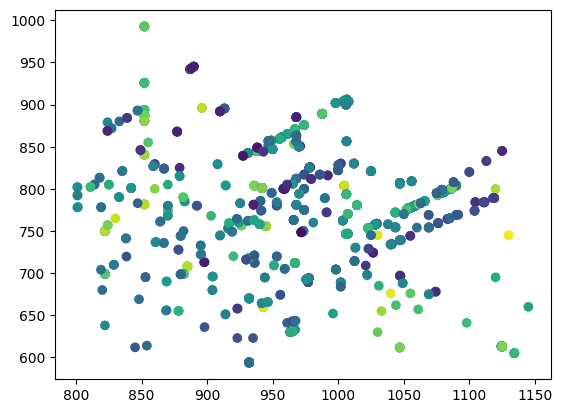

In [5]:
plt.scatter(x=data['Coarse'] , y=data['Fine'], c=data['Strength'])

Из данного графика видно отсутсвие прямой зависимости между наполнителями.

4) При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).
- при попытках составить новые признаки, видимые линейные зависимости не наблюдались.

Рассмотрим матрицу попарной корреляции для признаков

<AxesSubplot: >

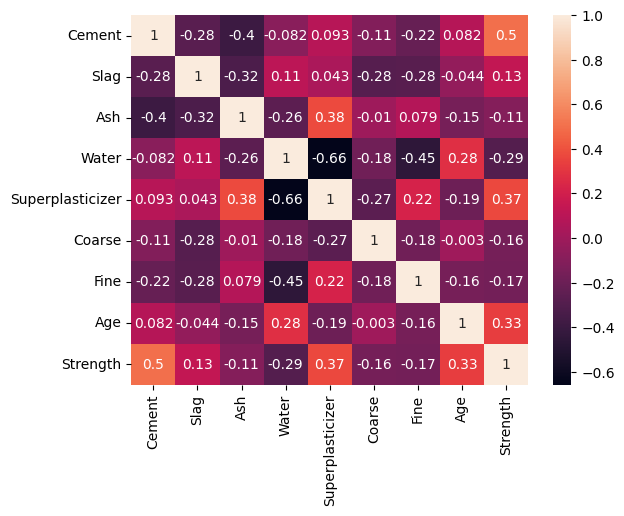

In [6]:
import seaborn
seaborn.heatmap(data.corr(), cbar = True , annot=True)

5) Перед обучением моделей подобрать наилучшее количество (и само подмножество) признаков, например используя Recursive Feature Elimination (RFE).
* зададимся целью убрать самый незначимый параметр. Сделаем это с помощью RFE. Укажем целевое количество параметров на 1 меньше текущего.
Как видим Крупный Наполнитель (Coarse) оказался наименее полезным параметром для линейной регрессии с точки зрения этого алгоритма.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

x = data.drop(['Strength'], axis=1)
y = data['Strength']

rfe = RFE(estimator=LinearRegression(), n_features_to_select=7)
rfe.fit(x, y)
x = rfe.transform(x)
rfe.get_feature_names_out()

array(['Cement', 'Slag', 'Ash', 'Water', 'Superplasticizer', 'Fine',
       'Age'], dtype=object)

6) Случайным образом разбить данные на обучающую и тестовую выборки, используя методы существующих библиотек.
- тестовая выборка 25%

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

7) При обучении моделей использовать масштабирование данных.
- в случае линейной регрессии очень важный пункт, так как параметры входят как слагаемые в одно выражение.
- воспользуемся стандартными средствами

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train) # запоминаем и примееняем масштаб на тренировочных данных
x_test = scaler.transform(x_test) # применяем к тестовым. То есть они могут выходить за пределы

8) Обучить модель на обучающей выборке, используя функцию gradient_descent(X, y). Оценить качество модели на обучающей и тестовой выборках, используя MSE, RMSE и R^2.

In [10]:
from functions import gradient_descent
w = gradient_descent(x_train, y_train, alpha=0.05, max_iteration_num=1000)
y_ans_my_grad = x_test.dot(w[1:])+ w[0]

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
from prettytable import PrettyTable

results = PrettyTable(["Exp", "MSE", "RMSE", "R^2"])
results.add_row(["My gradient",  mean_squared_error(y_test, y_ans_my_grad), np.sqrt(mean_squared_error(y_test, y_ans_my_grad)), r2_score(y_test, y_ans_my_grad)])

In [12]:
from sklearn.linear_model import Ridge
model = Ridge()
model.fit(x_train, y_train)
y_ans_Ridge = model.predict(x_test)
results.add_row(["Ridge",  mean_squared_error(y_test, y_ans_Ridge), np.sqrt(mean_squared_error(y_test, y_ans_Ridge)), r2_score(y_test, y_ans_Ridge)])

9) Повторить тоже самое, но используя кросс-валидацию.
- так как тестовая выборка составляет 25% от общего числа данных, а их колличество не так велико, разобьем тренировочную выборку на 4
- в качестве модели используем LinearRegression(), а для оценки результатов отдельно - отрицательную MSE и R^2

In [13]:
from sklearn.model_selection import cross_val_score
cross_scores = cross_val_score(LinearRegression(), x_train, y_train, cv=4, scoring='neg_mean_squared_error')
cross_scores_r2 = cross_val_score(LinearRegression(), x_train, y_train, cv=4, scoring='r2')
results.add_row(["Cross validation", abs(cross_scores.mean()), np.sqrt(abs(cross_scores.mean())), cross_scores_r2.mean()])

In [14]:
print(results)

+------------------+--------------------+--------------------+--------------------+
|       Exp        |        MSE         |        RMSE        |        R^2         |
+------------------+--------------------+--------------------+--------------------+
|   My gradient    | 105.91216448078714 | 10.291363587046526 | 0.6204821492683597 |
|      Ridge       | 105.80252404384547 | 10.286035389976329 | 0.6208750267360743 |
| Cross validation | 110.65155037335796 | 10.519104067046678 | 0.6010381630212831 |
+------------------+--------------------+--------------------+--------------------+


В итоге мы получили похожие резельтаты

10) Создать таблицу, со строками (mse-train, mse-test, rmse-train, rmse-test, r2-train, r2-test) и столбцами (Fold1, Fold2, ..., Foldk, E, STD), где k --- количество фолдов в кросс-валидации, E --- мат. ожидание и STD --- стандартное отклонение. Сделать выводы.

In [15]:
from sklearn.model_selection import KFold, cross_validate
from statistics import mean

scoring = {'neg_mse': 'neg_mean_squared_error',
           'neg_rmse': 'neg_root_mean_squared_error',
           'r2': 'r2'}

folds = KFold(n_splits = 6, random_state=13, shuffle=True)
val_score = cross_validate(LinearRegression(), x, y, cv = folds,
                                scoring=scoring,
                                return_train_score = True)

result_table = pd.DataFrame(val_score)
print(result_table)

   fit_time  score_time  test_neg_mse  train_neg_mse  test_neg_rmse  \
0  0.001035    0.000961   -120.315277    -105.369737     -10.968832   
1  0.000996    0.001034   -113.516873    -106.689716     -10.654430   
2  0.002033    0.000957   -122.031261    -105.029280     -11.046776   
3  0.000997    0.001021    -99.081921    -109.427109      -9.953990   
4  0.001041    0.000000   -100.107987    -109.288067     -10.005398   
5  0.002028    0.000000   -103.492805    -108.603909     -10.173141   

   train_neg_rmse   test_r2  train_r2  
0      -10.264976  0.520409  0.628667  
1      -10.329071  0.642069  0.604039  
2      -10.248379  0.544073  0.626074  
3      -10.460741  0.634805  0.609529  
4      -10.454093  0.650664  0.603653  
5      -10.421320  0.603101  0.614935  


In [16]:
result_table = abs(result_table)
result_table.drop(['fit_time', 'score_time'], axis = 1, inplace = True)
result_table.rename(columns = {"test_neg_mse" : "test_mse",
                                  "train_neg_mse" : "train_mse",
                                  "test_neg_rmse" : "test_rmse",
                                  "train_neg_rmse" : "train_rmse"},
                       inplace = True)
result_table = result_table.set_axis(['Fold1','Fold2','Fold3','Fold4','Fold5','Fold6'], axis=0)
result_table = result_table.transpose()
result_table['E'] = result_table.mean(axis = 1)
result_table['STD'] = result_table.std(axis = 1)
print(result_table)

                 Fold1       Fold2       Fold3       Fold4       Fold5  \
test_mse    120.315277  113.516873  122.031261   99.081921  100.107987   
train_mse   105.369737  106.689716  105.029280  109.427109  109.288067   
test_rmse    10.968832   10.654430   11.046776    9.953990   10.005398   
train_rmse   10.264976   10.329071   10.248379   10.460741   10.454093   
test_r2       0.520409    0.642069    0.544073    0.634805    0.650664   
train_r2      0.628667    0.604039    0.626074    0.609529    0.603653   

                 Fold6           E       STD  
test_mse    103.492805  109.757687  9.332490  
train_mse   108.603909  107.401303  1.796763  
test_rmse    10.173141   10.467095  0.444544  
train_rmse   10.421320   10.363097  0.086747  
test_r2       0.603101    0.599187  0.050027  
train_r2      0.614935    0.614483  0.009888  


В среднем по фолдам модель работает несколько лучше

11) Также самостоятельно реализовать метод стохастического градиентного спуска (Stochastic Gradient Descent, SGD), обучить модели и добавить их во все сравнения.

In [17]:
from functions import gradient_descent_rand
w_stoch = gradient_descent_rand(x_train, y_train, alpha = 0.05, max_iteration_num=1000)
y_ans_stoch = x_test.dot(w_stoch[1:])+ w_stoch[0]
results.add_row(["Stochastic",  mean_squared_error(y_test, y_ans_stoch), np.sqrt(mean_squared_error(y_test, y_ans_stoch)), r2_score(y_test, y_ans_stoch)])

c:\Users\stude\PROG\ML labs\1 lab\functions.py:49: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_diff = np.dot(x_elem, w) - y[i:i+1]


12) Также самостоятельно реализовать метод мини-пакетного градиентного спуска (Mini Batch Gradient Descent), обучить модели и добавить их во все сравнения.

In [19]:
from functions import gradient_descent_mini_batch
w_batch = gradient_descent_mini_batch(x_train, y_train, max_iteration_num = 1000)
y_ans_batch = x_test.dot(w_batch[1:])+ w_batch[0]
results.add_row(["Mini-Batch",  mean_squared_error(y_test, y_ans_batch), np.sqrt(mean_squared_error(y_test, y_ans_batch)), r2_score(y_test, y_ans_batch)])

C:\Users\stude\AppData\Local\Temp\ipykernel_13308\2889762513.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_batch = y[j:j+batch_size]


In [20]:
print(results)

+------------------+--------------------+--------------------+---------------------+
|       Exp        |        MSE         |        RMSE        |         R^2         |
+------------------+--------------------+--------------------+---------------------+
|   My gradient    | 105.91216448078714 | 10.291363587046526 |  0.6204821492683597 |
|      Ridge       | 105.80252404384547 | 10.286035389976329 |  0.6208750267360743 |
| Cross validation | 110.65155037335796 | 10.519104067046678 |  0.6010381630212831 |
|    Stochastic    | 208.6581104511877  | 14.445002957811663 | 0.25230989278360716 |
|    Mini-Batch    | 105.80215693861598 | 10.286017545124837 |  0.6208763421939196 |
+------------------+--------------------+--------------------+---------------------+
